# MNIST Classifier

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns
import torchvision
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.utils import make_grid
from torchvision.datasets import MNIST
from PIL import Image

import warnings
warnings.filterwarnings("ignore")

## Loading Data

- autorii SimpleNet au folosit un split de 60000 train si 10000 eval

In [2]:
BATCH_SIZE = 64

train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('SimpleNet_Pytorch/MNIST/data', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('SimpleNet_Pytorch/MNIST/data', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.1307,), (0.3081,))
                             ])),
  batch_size=BATCH_SIZE, shuffle=True)

## Faza 2

[GitHub Repo](https://github.com/Coderx7/SimpleNet_Pytorch/blob/master/cifar/models/simplenet.py) for simplenet310k - cel folosit pt MNIST

In procesul de evaluare, in setul de test, de salvat imaginile care au fost prezise incorect de catre model, cu tuple: `idx`, `clasa prezisa`, `clasa adevarata`. 
De salvat imaginile intr-un director separat format de genul: `"im14_0_9"`.

Pentru a incarca pe fork-ul de pe github: `git push origin master`



In [3]:
import sys

# Add the directory to the Python path in this notebook 
sys.path.append('/home/iustin/SimpleNet_Pytorch/MNIST')

from models.simplenet import simplenet_cifar_310k

In [4]:
import os 
os.getcwd()

'/home/iustin'

In [5]:
import models
# from torch.utils.tensorboard import SummaryWriter

model_names = sorted(name for name in models.__dict__
  if name.islower() and not name.startswith("__")
  and callable(models.__dict__[name]))

print('models : ',model_names)

models :  ['simplenet_cifar_310k', 'simplenet_cifar_460k', 'simplenet_cifar_5m', 'simplenet_cifar_5m_extra_pool']


In [6]:
net = models.__dict__['simplenet_cifar_310k'](num_classes=10)

In [20]:
from torchinfo import summary

summary(net, 
        input_size=(1, 1, 28, 28), # make sure this is "input_size", not "input_shape" (batch_size, color_channels, height, width)
        verbose=0,
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

Layer (type (var_name))                  Input Shape          Output Shape         Param #              Trainable
SimpleNet (SimpleNet)                    [1, 1, 28, 28]       [1, 10]              --                   True
├─Sequential (features)                  [1, 1, 28, 28]       [1, 64, 1, 1]        --                   True
│    └─Conv2d (0)                        [1, 1, 28, 28]       [1, 64, 28, 28]      640                  True
│    └─BatchNorm2d (1)                   [1, 64, 28, 28]      [1, 64, 28, 28]      128                  True
│    └─ReLU (2)                          [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Dropout2d (3)                     [1, 64, 28, 28]      [1, 64, 28, 28]      --                   --
│    └─Conv2d (4)                        [1, 64, 28, 28]      [1, 32, 28, 28]      18,464               True
│    └─BatchNorm2d (5)                   [1, 32, 28, 28]      [1, 32, 28, 28]      64                   True
│    └─ReLU (6)   

In [7]:
LEARNING_RATE = 0.1
MOMENTUM = 0.9 # default 
WEIGHT_DECAY = 0 # 0.005 
NUM_EPOCH = 150
EVAL_STEP = 1
SAVE_INTERVAL = 1 # checkpoint
MILESTONES = [20, 40, 60, 80, 100, 120]
STEP_SIZE= 20 # intre 10 si 100 la scheduler step_lr

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # use GPU if available

net = net.to(device)

criterion = nn.CrossEntropyLoss() 
# optimizer = torch.optim.Adadelta(net.parameters(), lr=LEARNING_RATE, rho=0.9, eps=1e-3, # momentum=state['momentum'], # default eps = 1e-6 
                                    #  weight_decay=0.001)

optimizer = torch.optim.SGD(net.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY) 
# optimizer = torch.optim.Adam(net.parameters(),lr=LEARNING_RATE,betas=(0.9,0.999),eps=1e-08,weight_decay=0)

# scheduler = lr_scheduler.MultiStepLR(optimizer, MILESTONES, gamma=0.1)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=STEP_SIZE, gamma=0.1)

In [22]:
#Break
abcd 

NameError: name 'abcd' is not defined

In [23]:
PATH1 = "SimpleNet_Pytorch/MNIST/checkpoint_loss"
PATH2 = "SimpleNet_Pytorch/MNIST/checkpoint_acc"

checkpoint_filename = 'checkpoint.pth'
checkpoint_path1 = os.path.join(PATH1, checkpoint_filename)
checkpoint_path2 = os.path.join(PATH2, checkpoint_filename)

In [24]:
def train(net, device, train_loader, criterion, optimizer, train_loss_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector)

In [25]:
def evaluation(net, device, test_loader, criterion, test_loss_collector, test_accuracy_collector):
    net.eval() 
    correct_test = 0
    test_loss = list()
    test_acc = list()
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            loss = criterion(output, target)
            test_loss.append(loss.item())
            preds = output.argmax(dim=1, keepdim=True)
            correct_test += preds.eq(target.view_as(preds)).sum().item()
            test_acc.append(correct_test)
            test_accuracy =  100. * correct_test / len(test_loader.dataset)
        test_loss_collector.append(np.round(np.mean(test_loss),5))
        test_accuracy_collector.append(test_accuracy)
        print(f'Test loss: {np.round(np.mean(test_loss), 5)} Test Accuracy: {correct_test}/{len(test_loader.dataset)}'
              f' - {(100. * correct_test / len(test_loader.dataset)):.3f}%')
    all_preds.extend(preds)
    all_targets.extend(target)

train1 difera de train. am adaugat train_accuracy_collector in train 

In [26]:
def train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector):
     for epoch in range(NUM_EPOCH):
        net.train()
        correct = 0
        epoch_loss = list()
        test_loss = list()
        accuracy = list() 
        test_accuracy = list()
        for batch_idx, (data, target) in enumerate(train_loader):
            data, target = data.to(device), target.to(device)
            optimizer.zero_grad()
            output = net(data)
            loss = criterion(output, target)
            loss.backward()
            optimizer.step()
            epoch_loss.append(loss.item())
            pred = torch.max(output.data, 1)[1]
            correct += pred.eq(target.view_as(pred)).sum().item()
            accuracy.append(correct)
            epoch_accuracy =  100. * correct / len(train_loader.dataset)
        train_loss_collector.append(np.round(np.mean(epoch_loss),5))
        train_accuracy_collector.append(epoch_accuracy)
        print(f'Epoch: {epoch}/{NUM_EPOCH} \t Loss: {np.round(np.mean(epoch_loss),5)}')
        print(f'Train Accuracy: {(100. * correct / len(train_loader.dataset)):.3f}%')
        scheduler.step()
        if epoch % EVAL_STEP == 0:
            evaluation(net, device, test_loader, criterion, test_loss_collector, test_accuracy_collector)
        if epoch % SAVE_INTERVAL == 0: 
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_loss': epoch_loss,
                'test_loss': test_loss,
                'train_loss_collector': train_loss_collector,
                'test_loss_collector': test_loss_collector,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path1)
            torch.save({
                'epoch': epoch,
                'net_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'epoch_accuracy': epoch_accuracy,
                'test_accuracy': test_accuracy,
                'train_accuracy_collector': train_accuracy_collector,
                'test_accuracy_collector': test_accuracy_collector,
                'LEARNING_RATE': LEARNING_RATE,
                'MOMENTUM': MOMENTUM,
                'WEIGHT_DECAY': WEIGHT_DECAY,
                'NUM_EPOCH': NUM_EPOCH,
                'EVAL_STEP': EVAL_STEP,
                'SAVE_INTERVAL': SAVE_INTERVAL,
                'MILESTONES': MILESTONES,
                'STEP_SIZE': STEP_SIZE,
            }, checkpoint_path2)

In [27]:
train_loss_collector = list()
train_accuracy_collector = list()
test_loss_collector = list()
test_accuracy_collector = list()
all_preds = list()
all_targets = list()
print('Start training...')
train1(net, device, train_loader, criterion, optimizer, train_loss_collector, train_accuracy_collector)
print('Finish training!')

Start training...
Epoch: 0/150 	 Loss: 0.1167
Train Accuracy: 96.420%
Test loss: 0.1084 Test Accuracy: 9661/10000 - 96.610%
Epoch: 1/150 	 Loss: 0.03859
Train Accuracy: 98.840%
Test loss: 0.03065 Test Accuracy: 9897/10000 - 98.970%
Epoch: 2/150 	 Loss: 0.02884
Train Accuracy: 99.118%
Test loss: 0.02225 Test Accuracy: 9926/10000 - 99.260%
Epoch: 3/150 	 Loss: 0.02404
Train Accuracy: 99.253%
Test loss: 0.02 Test Accuracy: 9933/10000 - 99.330%
Epoch: 4/150 	 Loss: 0.01855
Train Accuracy: 99.433%
Test loss: 0.02122 Test Accuracy: 9945/10000 - 99.450%
Epoch: 5/150 	 Loss: 0.01336
Train Accuracy: 99.590%
Test loss: 0.02256 Test Accuracy: 9923/10000 - 99.230%
Epoch: 6/150 	 Loss: 0.01359
Train Accuracy: 99.577%
Test loss: 0.02436 Test Accuracy: 9923/10000 - 99.230%
Epoch: 7/150 	 Loss: 0.01073
Train Accuracy: 99.663%
Test loss: 0.01991 Test Accuracy: 9936/10000 - 99.360%
Epoch: 8/150 	 Loss: 0.00822
Train Accuracy: 99.758%
Test loss: 0.0163 Test Accuracy: 9947/10000 - 99.470%
Epoch: 9/150 	 L

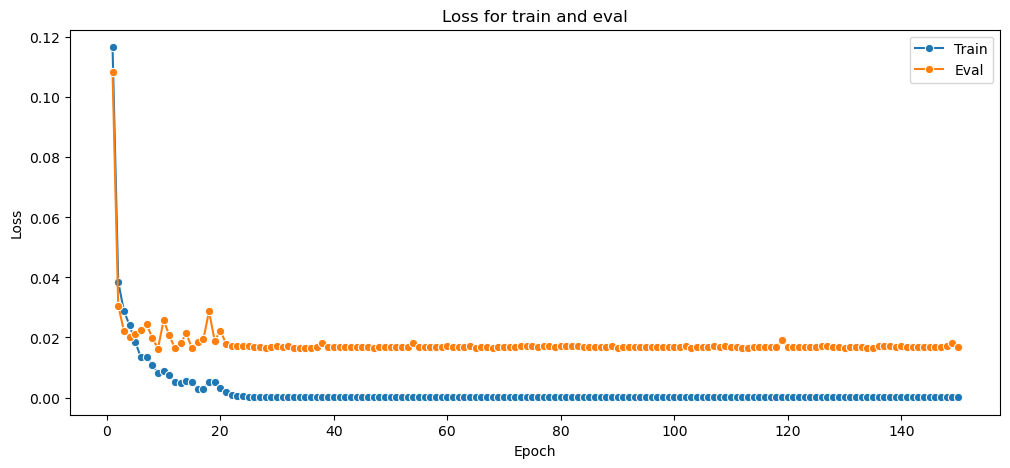

In [28]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_loss_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_loss_collector, label='Eval', marker='o')
plt.title('Loss for train and eval')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show();

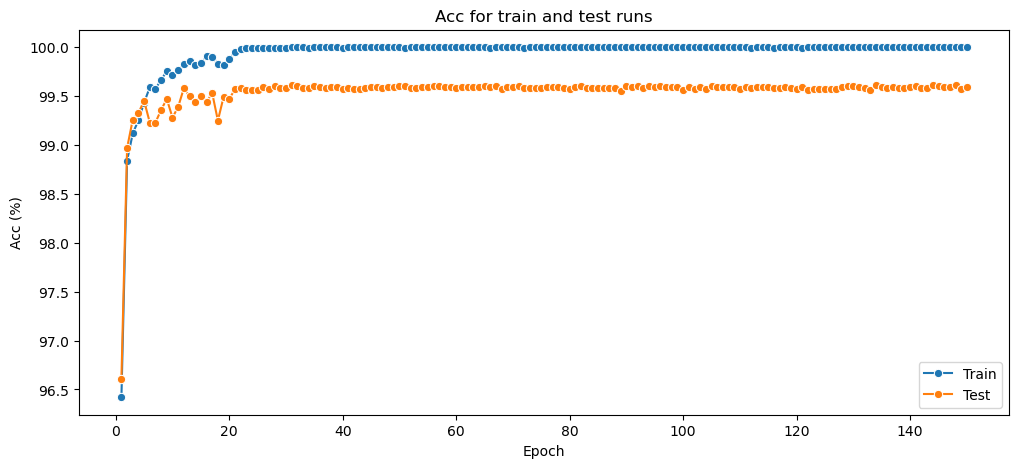

In [29]:
plt.figure(figsize=(12,5))
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=train_accuracy_collector, label='Train', marker='o')
sns.lineplot(x=range(1, NUM_EPOCH + 1), y=test_accuracy_collector, label='Test', marker='o')
plt.title('Acc for train and test runs')
plt.ylabel('Acc (%)')
plt.xlabel('Epoch')
plt.show();

In [8]:
# check if checkpoints are ok

checkpoint_path1 = "SimpleNet_Pytorch/MNIST/checkpoint_loss/checkpoint.pth"
checkpoint = torch.load(checkpoint_path1)
net.load_state_dict(checkpoint['net_state_dict'])
optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

In [45]:
# checkpoint

In [32]:
data = {
    'Train Loss': train_loss_collector,
    'Train Accuracy': train_accuracy_collector,
    'Test Loss': test_loss_collector,
    'Test Accuracy': test_accuracy_collector
}

df = pd.DataFrame(data)

df.index.name = 'Epoch'

print(df)

       Train Loss  Train Accuracy  Test Loss  Test Accuracy
Epoch                                                      
0         0.11670       96.420000    0.10840          96.61
1         0.03859       98.840000    0.03065          98.97
2         0.02884       99.118333    0.02225          99.26
3         0.02404       99.253333    0.02000          99.33
4         0.01855       99.433333    0.02122          99.45
...           ...             ...        ...            ...
145       0.00014       99.998333    0.01693          99.59
146       0.00011      100.000000    0.01680          99.59
147       0.00012      100.000000    0.01723          99.61
148       0.00016       99.998333    0.01807          99.57
149       0.00013      100.000000    0.01692          99.59

[150 rows x 4 columns]


In [33]:
# pe jupyterhub
file_path = 'SimpleNet_Pytorch/MNIST/training_test_metrics.csv' 
df.to_csv(file_path, index=True)

In [92]:
# preds = [tensor.item() for tensor in all_preds]
# targets = [tensor.item() for tensor in all_targets]
# confusion_mtx = confusion_matrix(targets, preds)
# f,ax = plt.subplots(figsize=(10, 10))
# sns.heatmap(confusion_mtx, annot=True, linewidths=0.01,cmap="Greens",linecolor="gray", fmt= '.1f',ax=ax)
# plt.xlabel("Predicted Label")
# plt.ylabel("True Label")
# plt.title("Confusion Matrix Test Set")
# plt.show()

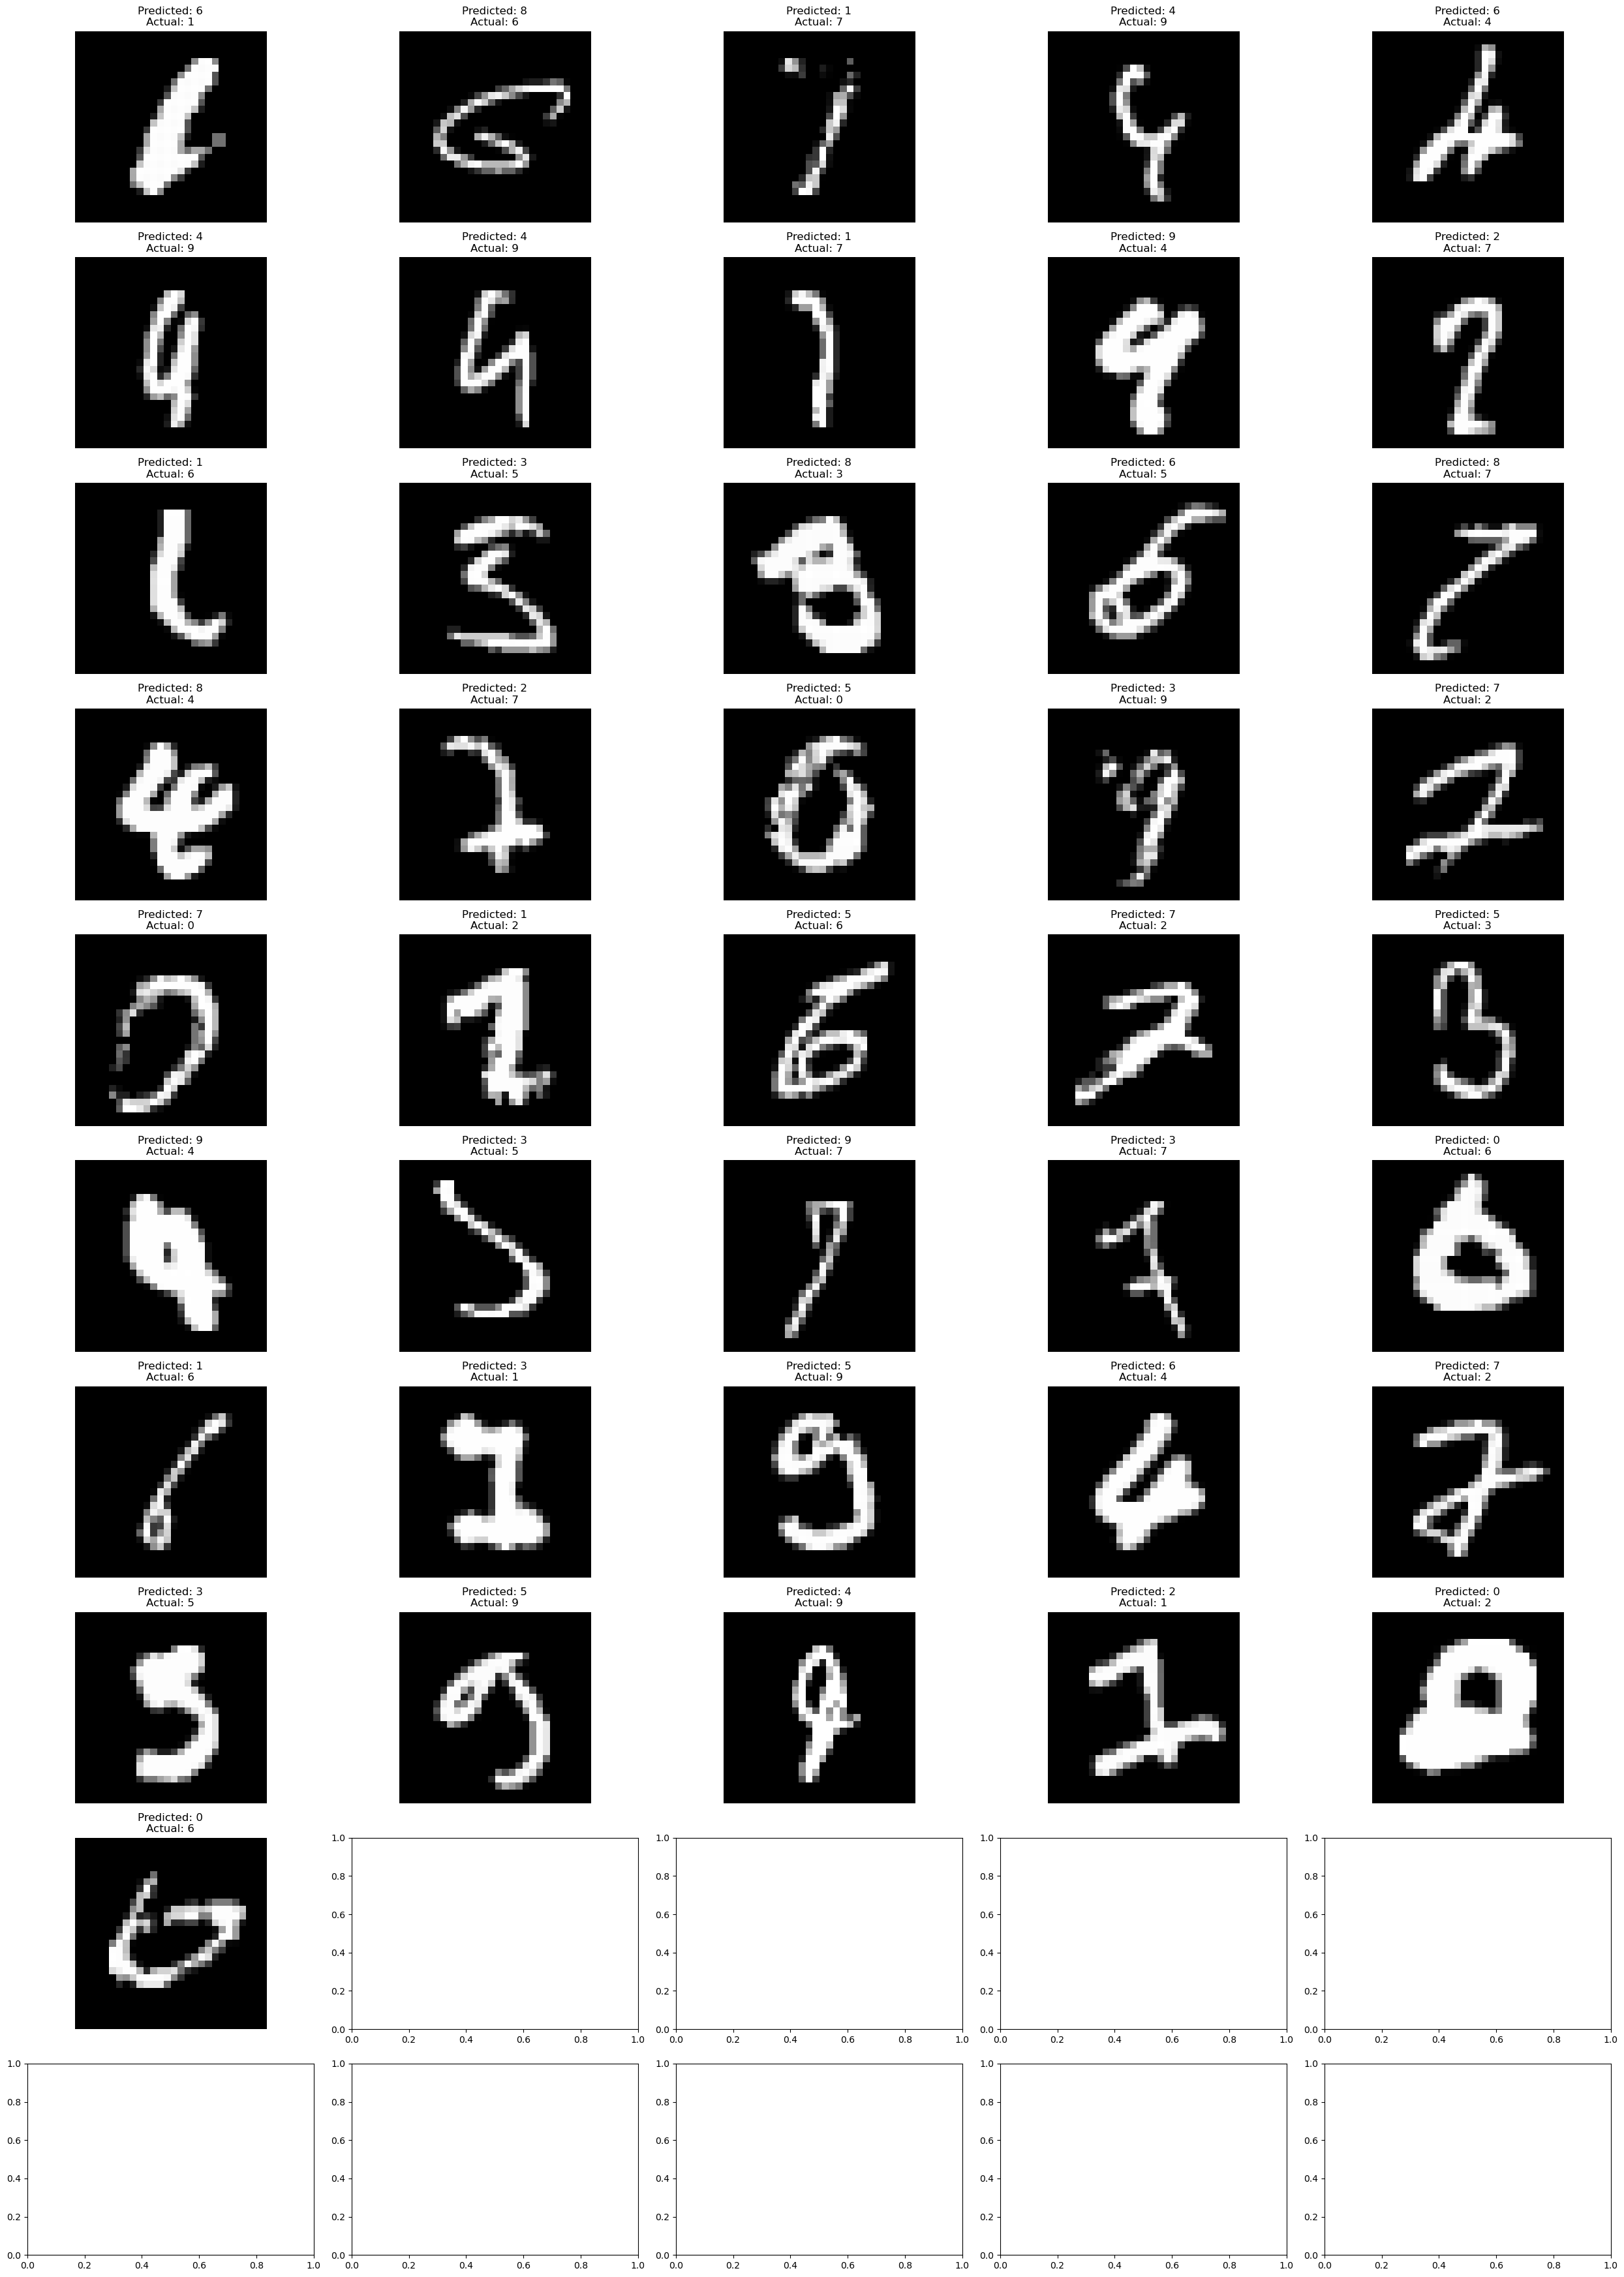

In [10]:
def plot_misclassified_images(net, device, test_loader, classes):
    net.eval()  
    misclassified = []

    with torch.no_grad(): 
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_images = data[misclassified_mask]
            misclassified_preds = pred[misclassified_mask]
            misclassified_targets = target.view_as(pred)[misclassified_mask]

            # Store the misclassified images and their predicted/actual labels
            for image, pred, actual in zip(misclassified_images, misclassified_preds, misclassified_targets):
                misclassified.append((image, pred, actual))

            # Stop after collecting a certain number of misclassified images
            if len(misclassified) >= 50:
                break

    # Plot the misclassified images
    fig, axes = plt.subplots(10, 5, figsize=(25, 35))
    for i, (image, pred, actual) in enumerate(misclassified[:50]):
        ax = axes[i//5, i%5]
        ax.imshow(image.cpu().numpy().squeeze(), cmap='gray')
        ax.set_title(f'Predicted: {classes[pred.item()]}\nActual: {classes[actual.item()]}')
        ax.axis('off')
    plt.tight_layout()
    plt.show()

classes = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
plot_misclassified_images(net, device, test_loader, classes)

In [85]:
from pathlib import Path
from PIL import Image
def save_misclassified_samples(net, device, test_loader, save_dir):
    net.eval()  
    misclassified_samples = []

    with torch.no_grad():  
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = net(data)
            pred = output.argmax(dim=1, keepdim=True)  

            # Check for misclassified images
            misclassified_mask = ~pred.eq(target.view_as(pred))
            misclassified_data = data[misclassified_mask].cpu()
            misclassified_targets = target[misclassified_mask.squeeze()].cpu()

            for img, label in zip(misclassified_data, misclassified_targets):
                misclassified_samples.append((img, label.item()))
    # Save the misclassified images to the set path
    if misclassified_samples:
        save_dir = Path(save_dir)
        save_dir.mkdir(parents=True, exist_ok=True)
        for i, (img, label) in enumerate(misclassified_samples):
            img = transforms.ToPILImage()(img.squeeze())
            # Convert grayscale image to RGB with a single channel
            img = img.convert('L')  
            image_3_channel = np.stack((img,)*3, axis=-1)
            image_3_channel_pil = Image.fromarray(image_3_channel)
            # Save 
            image_3_channel_pil.save(save_dir / f'misclassified_{i}_{label}.jpeg')
    else:
        return None
save_misclassified_samples(net.to(device), device, test_loader, 'SimpleNet_Pytorch/MNIST/misclassified_samples')

se salveaza doar cateva ca grayscale by default, dar tot nu merge guided backprop

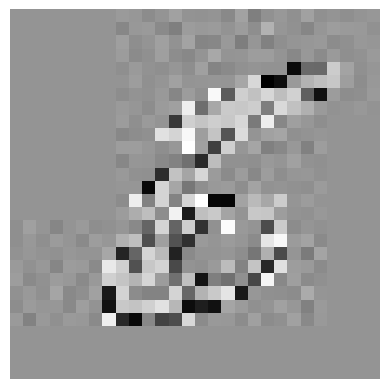

In [87]:
image_path = 'SimpleNet_Pytorch/MNIST/misclassified_samples/misclassified_0_6.jpeg'
image = Image.open(image_path)

# Display the image
plt.imshow(image)  # Use cmap='gray' if it's a grayscale image
plt.axis('off')  
plt.show()

## Guided backpropagation

Layer-wise backprop pentru neuronii nu doar din fully-connected layers (pt clasificare) 

! Cea mai simpla implementare 

> Guided backpropagation implementation: 

> 1. https://github.com/ashutosh1919/explainable-cnn
> 2. https://github.com/hans66hsu/nn_interpretability/blob/main/6.Backpropagation.ipynb


# De facut:

1. splitul dintre train validation si test
este train val split standardizat? daca nu, facem cum consideram?

2. guided backprop

3. cnn layer visualization

In [33]:
# 1
from explainable_cnn import CNNExplainer

classes_dict = {i: class_name for i, class_name in enumerate(classes)}
x_cnn = CNNExplainer(net, classes_dict)

In [ ]:
# Perform guided backpropagation on the grayscale image
guided_backprop = x_cnn.get_guided_back_propagation(
    'SimpleNet_Pytorch/MNIST/misclassified_samples/misclassified_0_6.jpeg',
    1, # The channel index of the grayscale image
    (28, 28)
)

# Display the guided backpropagation result
plt.imshow(guided_backprop.astype('uint8'), cmap='gray')
plt.axis('off')
plt.show()

TypeError: Invalid type for attribute image_shape.

In [72]:
# Specify the path to the image
image_path = 'SimpleNet_Pytorch/MNIST/misclassified_samples/misclassified_11_3.jpeg'

# Load the image
image = Image.open(image_path).convert('L') # convert to grayscale

image_3_channel = np.stack((image,)*3, axis=-1)

# Now, convert this array back to an Image object
image_3_channel_pil = Image.fromarray(image_3_channel)

image_3_channel_pil.save('SimpleNet_Pytorch/MNIST/misclassified_samples/misclassified_11_3_3channel.jpeg')
image_3_channel_pil_path = 'SimpleNet_Pytorch/MNIST/misclassified_samples/misclassified_11_3_3channel.jpeg'

In [91]:

# Perform guided backpropagation on the image
guided_backprop = x_cnn.get_guided_back_propagation(image_path, 1, (28, 28))

# Create a figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

# Display the original image
ax1.imshow(image_3_channel_pil)
ax1.set_title('Original Image')
ax1.axis('off')

# Display the guided backpropagation result
ax2.imshow(guided_backprop.astype('uint8'), cmap='gray')
ax2.set_title('Guided Backpropagation')
ax2.axis('off')

# Show the figure
plt.tight_layout()
plt.show()


RuntimeError: Given groups=1, weight of size [64, 1, 3, 3], expected input[1, 3, 28, 28] to have 1 channels, but got 3 channels instead